In [2]:
from confluent_kafka import Consumer
import json
from pyspark.sql.functions import col, sum as spark_sum, when


In [3]:
# Step 1: Configure the Kafka consumer
consumer_config = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'heart_consumer_group',
    'auto.offset.reset': 'earliest'
}
consumer = Consumer(consumer_config)
spark = SparkSession.builder.appName("HeartDiseaseProcessing").getOrCreate()


25/03/23 11:36:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Step 2: Subscribe to the Kafka topic
topic1 = 'heart_data'
topic2='test'
consumer.subscribe([topic1,topic2])

print(f"Subscribed to topic: {topic1,topic2}")

Subscribed to topic: ('heart_data', 'test')


In [5]:
# Step 3: Variable to store received data
received_rdd = spark.sparkContext.emptyRDD()

In [6]:
def consume_messages():
    global received_rdd 
    try:
        while True:
            msg = consumer.poll(1.0)  # Poll Kafka for new messages
            
            if msg is None:
                continue  # No new message, continue polling
            if msg.error():
                print(f"Consumer error: {msg.error()}") 
                continue
            topic = msg.topic()
            if topic != "heart_data":
                continue
                
            # Decode the received message
            data = json.loads(msg.value().decode('utf-8'))
            
            # Check for termination signal
            if isinstance(data, dict) and data.get("end_of_stream"):
                print("End of stream signal received. Stopping consumer...")
                break
            
            # Convert batch to RDD and append to existing RDD
            batch_rdd = spark.sparkContext.parallelize(data)  
            received_rdd = received_rdd.union(batch_rdd)

            print(f"Received batch with {len(data)} records, Total stored in RDD: {received_rdd.count()}")

    except KeyboardInterrupt:
        print("Consumer interrupted. Closing connection...")
    finally:
        #consumer.close()
        print(f"Total number of records received in RDD: {received_rdd.count()}")

In [7]:
consume_messages()

Consumer error: KafkaError{code=UNKNOWN_TOPIC_OR_PART,val=3,str="Subscribed topic not available: heart_data: Broker: Unknown topic or partition"}
Consumer error: KafkaError{code=UNKNOWN_TOPIC_OR_PART,val=3,str="Subscribed topic not available: test: Broker: Unknown topic or partition"}


Received batch with 50 records, Total stored in RDD: 50
Received batch with 50 records, Total stored in RDD: 100
Received batch with 50 records, Total stored in RDD: 150
Received batch with 50 records, Total stored in RDD: 200
Received batch with 50 records, Total stored in RDD: 250
Received batch with 50 records, Total stored in RDD: 300


Received batch with 50 records, Total stored in RDD: 350


Received batch with 50 records, Total stored in RDD: 400


Received batch with 50 records, Total stored in RDD: 450


Received batch with 50 records, Total stored in RDD: 500


Received batch with 50 records, Total stored in RDD: 550


Received batch with 50 records, Total stored in RDD: 600


Received batch with 50 records, Total stored in RDD: 650


Received batch with 50 records, Total stored in RDD: 700


Received batch with 50 records, Total stored in RDD: 750


Received batch with 50 records, Total stored in RDD: 800


Received batch with 50 records, Total stored in RDD: 850


Received batch with 50 records, Total stored in RDD: 900


Received batch with 20 records, Total stored in RDD: 920
End of stream signal received. Stopping consumer...


Total number of records received in RDD: 920


In [8]:
df = spark.createDataFrame(received_rdd)
df.show(5)  # Display first 5 rows


+---+---+-----+---------------+---------+-----+-----+---+---+-------+--------------+------+-----------+-----------------+------+--------+
|age| ca| chol|             cp|  dataset|exang|  fbs| id|num|oldpeak|       restecg|   sex|      slope|             thal|thalch|trestbps|
+---+---+-----+---------------+---------+-----+-----+---+---+-------+--------------+------+-----------+-----------------+------+--------+
| 63|0.0|233.0| typical angina|Cleveland|false| true|  1|  0|    2.3|lv hypertrophy|  Male|downsloping|     fixed defect| 150.0|   145.0|
| 67|3.0|286.0|   asymptomatic|Cleveland| true|false|  2|  2|    1.5|lv hypertrophy|  Male|       flat|           normal| 108.0|   160.0|
| 67|2.0|229.0|   asymptomatic|Cleveland| true|false|  3|  1|    2.6|lv hypertrophy|  Male|       flat|reversable defect| 129.0|   120.0|
| 37|0.0|250.0|    non-anginal|Cleveland|false|false|  4|  0|    3.5|        normal|  Male|downsloping|           normal| 187.0|   130.0|
| 41|0.0|204.0|atypical angina|Cle

In [9]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- ca: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- cp: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- id: long (nullable = true)
 |-- num: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- restecg: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- slope: string (nullable = true)
 |-- thal: string (nullable = true)
 |-- thalch: double (nullable = true)
 |-- trestbps: double (nullable = true)



In [10]:
df.describe()

DataFrame[summary: string, age: string, ca: string, chol: string, cp: string, dataset: string, id: string, num: string, oldpeak: string, restecg: string, sex: string, slope: string, thal: string, thalch: string, trestbps: string]

In [11]:
## Dataset Description:

#| Variable   | Description                                                                                   |
#|------------|-----------------------------------------------------------------------------------------------|
#| age        | Age of the patient in years                                                                   |
#| sex        | Gender of the patient (0 = male, 1 = female)                                                  |
#| cp         | Chest pain type: 0: Typical angina, 1: Atypical angina, 2: Non-anginal pain, 3: Asymptomatic |
#| trestbps   | Resting blood pressure in mm Hg                                                               |
#| chol       | Serum cholesterol in mg/dl                                                                    |
#| fbs        | Fasting blood sugar level, categorized as above 120 mg/dl (1 = true, 0 = false)               |
#| restecg    | Resting electrocardiographic results: 0: Normal, 1: Having ST-T wave abnormality, 2: Showing probable or definite left ventricular hypertrophy |
#| thalach    | Maximum heart rate achieved during a stress test                                              |
#| exang      | Exercise-induced angina (1 = yes, 0 = no)                                                     |
#| oldpeak    | ST depression induced by exercise relative to rest                                             |
#| slope      | Slope of the peak exercise ST segment: 0: Upsloping, 1: Flat, 2: Downsloping                   |
#| ca         | Number of major vessels (0-4) colored by fluoroscopy                                           |
#| thal       | Thalium stress test result: 0: Normal, 1: Fixed defect, 2: Reversible defect, 3: Not described |
#| target     | Heart disease status ( 0 = no heart disease.
#                                      1 = Mild Heart Disease types.
#                                      2 = Moderate Heart Disease type.
#                                      3 =  Severe Heart Disease type.
#                                      4 =  Critical Heart Disease type.)                                 |


# EDA

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Age column

In [13]:
from pyspark.sql.functions import min, max, avg, stddev

df.select(
    min("age").alias("Min Age"),
    max("age").alias("Max Age"),
    avg("age").alias("Average Age"),
    stddev("age").alias("Std Dev Age")
).show()


+-------+-------+-----------------+----------------+
|Min Age|Max Age|      Average Age|     Std Dev Age|
+-------+-------+-----------------+----------------+
|     28|     77|53.51086956521739|9.42468520957686|
+-------+-------+-----------------+----------------+



In [14]:
# Convert the 'age' column from PySpark DataFrame to Pandas DataFrame
df_pandas = df.select("age").toPandas()

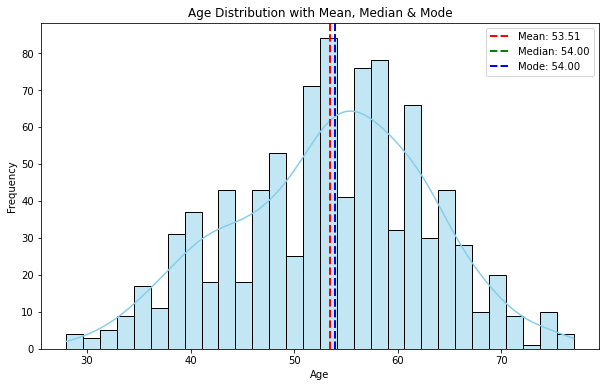

In [15]:
# Calculate central tendency metrics
mean_age = df_pandas["age"].mean()   # Mean (Average)
median_age = df_pandas["age"].median()  # Median
mode_age = df_pandas["age"].mode()[0]  # Mode (first mode if multiple exist)

# Create a histogram with KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas["age"], kde=True, bins=30, color="skyblue")

#  Add vertical lines for Mean, Median, and Mode
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_age:.2f}")
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2, label=f"Median: {median_age:.2f}")
plt.axvline(mode_age, color='blue', linestyle='dashed', linewidth=2, label=f"Mode: {mode_age:.2f}")

#  Customize the plot with titles and labels
plt.title("Age Distribution with Mean, Median & Mode")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()  # Display the legend
plt.show()  # Show the plot

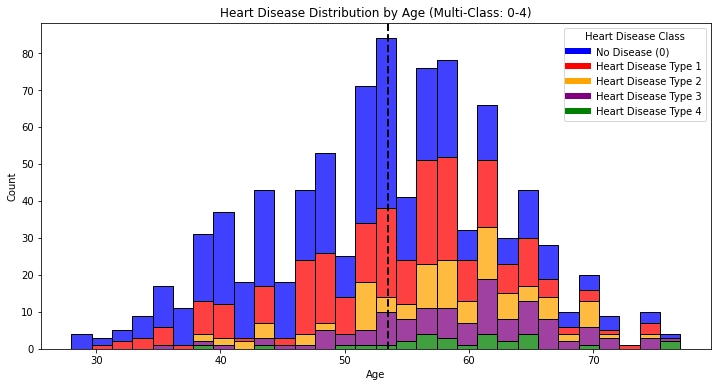

In [16]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("age", "num").toPandas()

# Calculate the mean age
mean_age = df_pandas["age"].mean()

# Define color mapping for all 5 heart disease classes (0-4)
color_mapping = {0: "blue", 1: "red", 2: "orange", 3: "purple", 4: "green"}
labels_mapping = {
    0: "No Disease (0)",
    1: "Heart Disease Type 1",
    2: "Heart Disease Type 2",
    3: "Heart Disease Type 3",
    4: "Heart Disease Type 4"
}

# Histogram with Multi-Class Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_pandas, x="age", hue="num", multiple="stack", bins=30, palette=color_mapping)

# Add an indicator line at the mean age
plt.axvline(mean_age, color='black', linestyle='dashed', linewidth=2, label=f"Mean Age: {mean_age:.2f}")

# Customize the plot
plt.title("Heart Disease Distribution by Age (Multi-Class: 0-4)")
plt.xlabel("Age")
plt.ylabel("Count")

# Modify the legend to include color explanations
handles = [plt.Line2D([0], [0], color=color_mapping[key], lw=6) for key in labels_mapping]
plt.legend(handles, labels_mapping.values(), title="Heart Disease Class")

plt.show()

Key Insights from Age Graphs
#Heart disease is more common in older individuals (50+), especially severe cases (num = 3-4).
#Younger people (<40) mostly fall in the num = 0 (healthy) category, with fewer cases of disease.
#The highest risk group appears to be between ages 55-65.
#Preventive care is crucial in middle age to reduce risk.
#Let me know if you need further analysis.

# Gender column 

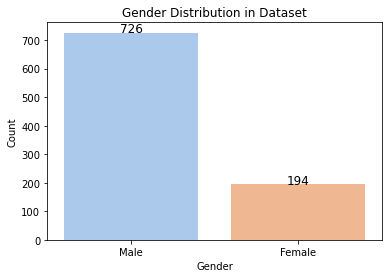

Male      726
Female    194
Name: sex, dtype: int64


In [17]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("sex").toPandas()

# Count the number of males and females
gender_counts = df_pandas["sex"].value_counts()

# Bar plot for gender distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel")

# Customize the plot
plt.title("Gender Distribution in Dataset")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show value labels on bars
for i, value in enumerate(gender_counts.values):
    plt.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.show()

# Print gender distribution
print(gender_counts)

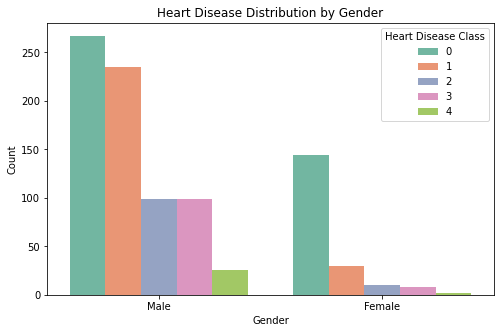

In [18]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("sex", "num").toPandas()

# Countplot: Heart Disease Cases by Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=df_pandas, x="sex", hue="num", palette="Set2")

# Customize the plot
plt.title("Heart Disease Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Heart Disease Class")
plt.show()



Males are 274.23% more than females in the data.


# Cp column 
**Types of Chest pain :**

    1. Asymptomatic: No chest pain or discomfort.
    2. Non-Anginal: Chest pain not typical of heart-related issues; requires further investigation.
    3. Atypical Angina: Chest pain with characteristics different from typical heart-related chest pain.
    4. Typical Angina: Classic chest pain indicating potential insufficient blood supply to the heart.

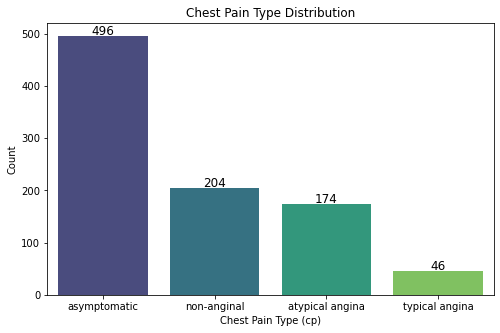

asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: cp, dtype: int64


In [19]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("cp").toPandas()

# Count occurrences of each chest pain type
cp_counts = df_pandas["cp"].value_counts()

# Bar plot for chest pain type distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=cp_counts.index, y=cp_counts.values, palette="viridis")

# Customize the plot
plt.title("Chest Pain Type Distribution")
plt.xlabel("Chest Pain Type (cp)")
plt.ylabel("Count")

# Show value labels on bars
for i, value in enumerate(cp_counts.values):
    plt.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.show()

# Print cp distribution
print(cp_counts)

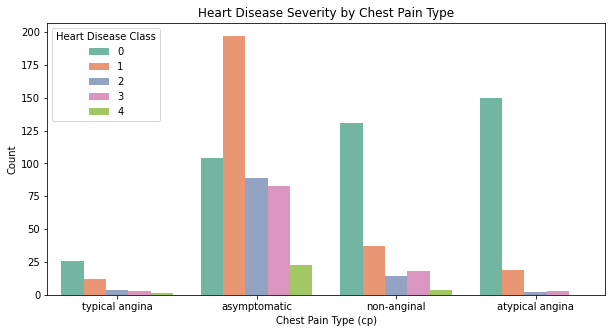

In [20]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("cp", "num").toPandas()

# Countplot: Distribution of Heart Disease by Chest Pain Type
plt.figure(figsize=(10, 5))
sns.countplot(data=df_pandas, x="cp", hue="num", palette="Set2")

# Customize the plot
plt.title("Heart Disease Severity by Chest Pain Type")
plt.xlabel("Chest Pain Type (cp)")
plt.ylabel("Count")
plt.legend(title="Heart Disease Class")
plt.show()



#  Trestbps column
The normal resting blood pressure is 120/80 mm Hg.

high blood pressure increasing the risk of heart disease and stroke, often asymptomatic, while low blood pressure can lead to dizziness and fainting

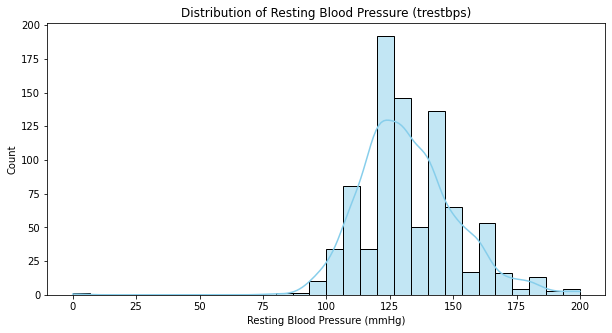

In [21]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("trestbps", "num").toPandas()

# Histogram: Distribution of Resting Blood Pressure
plt.figure(figsize=(10, 5))
sns.histplot(df_pandas["trestbps"], bins=30, kde=True, color="skyblue")

# Customize the plot
plt.title("Distribution of Resting Blood Pressure (trestbps)")
plt.xlabel("Resting Blood Pressure (mmHg)")
plt.ylabel("Count")
plt.show()



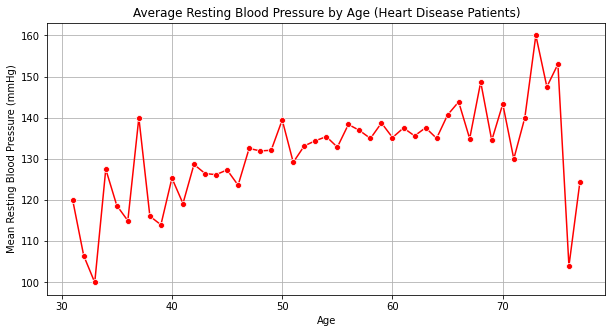

In [22]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("age", "trestbps", "num").toPandas()

# Filter only people with heart disease (`num > 0`)
df_heart_disease = df_pandas[df_pandas["num"] > 0]

# Group by age and calculate average resting blood pressure
bp_by_age = df_heart_disease.groupby("age")["trestbps"].mean().reset_index()

# 1️ Line plot: Mean Blood Pressure by Age for Heart Disease Patients
plt.figure(figsize=(10, 5))
sns.lineplot(data=bp_by_age, x="age", y="trestbps", marker="o", color="red")

# Customize the plot
plt.title("Average Resting Blood Pressure by Age (Heart Disease Patients)")
plt.xlabel("Age")
plt.ylabel("Mean Resting Blood Pressure (mmHg)")
plt.grid(True)
plt.show()

**This graph shows how average blood pressure changes with age among heart disease patients.
we see higher blood pressure in older age groups.**

# Dataset Column

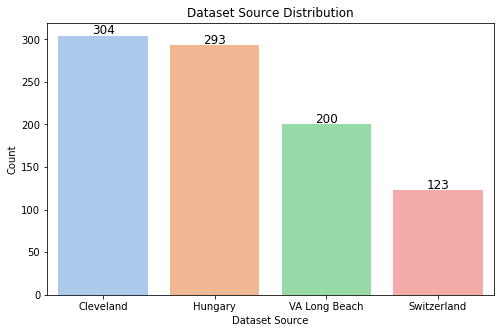

Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: dataset, dtype: int64


In [23]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("dataset").toPandas()

# Count occurrences of each dataset source
dataset_counts = df_pandas["dataset"].value_counts()

#  Bar plot for dataset distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=dataset_counts.index, y=dataset_counts.values, palette="pastel")

# Customize the plot
plt.title("Dataset Source Distribution")
plt.xlabel("Dataset Source")
plt.ylabel("Count")

# Show value labels on bars
for i, value in enumerate(dataset_counts.values):
    plt.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.show()

# Print dataset source distribution
print(dataset_counts)

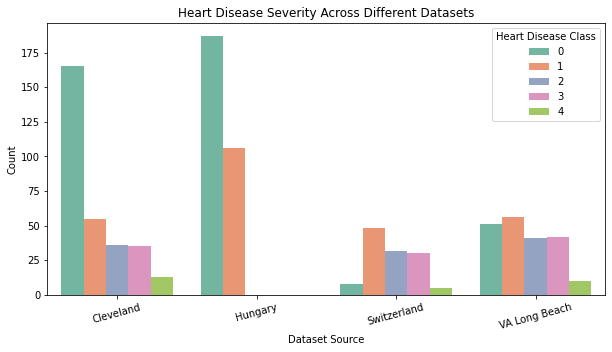

In [24]:
# Convert PySpark DataFrame to Pandas
df_pandas = df.select("dataset", "num").toPandas()

#  Countplot: Distribution of Heart Disease Classes by Dataset
plt.figure(figsize=(10, 5))
sns.countplot(data=df_pandas, x="dataset", hue="num", palette="Set2")

# Customize the plot
plt.title("Heart Disease Severity Across Different Datasets")
plt.xlabel("Dataset Source")
plt.ylabel("Count")
plt.legend(title="Heart Disease Class")
plt.xticks(rotation=15)  # Rotate labels if necessary
plt.show()


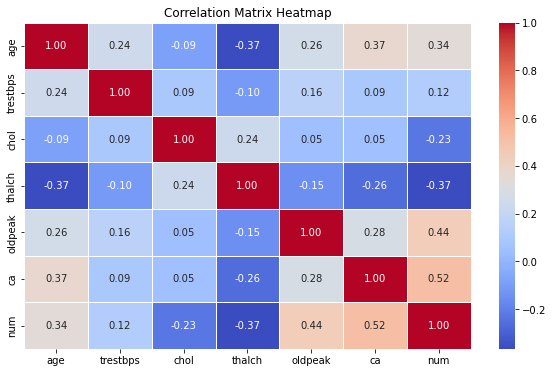

In [25]:


# Convert PySpark DataFrame to Pandas (numeric columns only)
numeric_columns = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca", "num"]
df_pandas = df.select(numeric_columns).toPandas()

# Compute correlation matrix
correlation_matrix = df_pandas.corr()

# 1️⃣ Heatmap for Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize the plot
plt.title("Correlation Matrix Heatmap")
plt.show()






# Conclusions Based on Our Analysis
**1. Age and Heart Disease  
    *The minimum recorded age for heart disease in the dataset is 28 years old.  
    *Heart disease cases peak between 53-55 years old, affecting both males and females.  
    *Older individuals (55+) have a higher probability of severe heart disease (num = 3, 4).**

**2. Gender Differences  
    *Males (78.91%) significantly outnumber females (21.09%) in the dataset.  
    *Males have a higher prevalence of severe heart disease, while females have fewer cases overall.**

**3. Chest Pain Type (cp) and Heart Disease  
    *Asymptomatic chest pain (cp = asymptomatic) is the most common among individuals with severe heart disease.  
    *197 individuals with mild heart disease had no chest pain symptoms, highlighting the risk of undiagnosed heart disease.  
    *The majority of people with critical heart disease (num = 4) reported asymptomatic or atypical angina.**

**4. Resting Blood Pressure (trestbps) and Heart Disease  
    *Higher resting blood pressure is associated with more severe heart disease.
    *Individuals above 50 years old with high blood pressure are more likely to have severe heart disease (num = 3, 4).   
    *The mean blood pressure tends to increase with age, showing that hypertension is a key risk factor.**

**5. Dataset Variability and Generalizability  
    *Most patients come from Cleveland (304) and the least from Switzerland (123).**

# Final Observations
**Age, gender, chest pain type, and blood pressure are key predictors of heart disease.
Undiagnosed or asymptomatic cases pose a major risk, especially in older patients.**

# Preprocessing the data and Missing Values

In [26]:
df.select(
    *[spark_sum(when(col(c).isNull() | (col(c) == "") | (col(c) == "NaN"), 1).otherwise(0)).alias(c) for c in df.columns]
).show()


+---+---+----+---+-------+-----+---+---+---+-------+-------+---+-----+----+------+--------+
|age| ca|chol| cp|dataset|exang|fbs| id|num|oldpeak|restecg|sex|slope|thal|thalch|trestbps|
+---+---+----+---+-------+-----+---+---+---+-------+-------+---+-----+----+------+--------+
|  0|611|  30|  0|      0|   55| 90|  0|  0|     62|      2|  0|  309| 486|    55|      59|
+---+---+----+---+-------+-----+---+---+---+-------+-------+---+-----+----+------+--------+



# Summary: Why We Dropped These Columns

**ca- Number of major vessels seen in fluoroscopy	611 missing values (too much data missing)  
slope-Change in ST segment during exercise 309 missing values (loss of key medical data)  
thal-Thalassemia blood disorder type	486 missing values (incomplete data for analysis)**


In [27]:
# Define columns to drop (too many missing values)
columns_to_drop = ["ca", "slope", "thal"]

#  Drop these columns from the DataFrame
df_cleaned = df.drop(*columns_to_drop)

#  Show the updated DataFrame after removing columns
df_cleaned.show(5)


+---+-----+---------------+---------+-----+-----+---+---+-------+--------------+------+------+--------+
|age| chol|             cp|  dataset|exang|  fbs| id|num|oldpeak|       restecg|   sex|thalch|trestbps|
+---+-----+---------------+---------+-----+-----+---+---+-------+--------------+------+------+--------+
| 63|233.0| typical angina|Cleveland|false| true|  1|  0|    2.3|lv hypertrophy|  Male| 150.0|   145.0|
| 67|286.0|   asymptomatic|Cleveland| true|false|  2|  2|    1.5|lv hypertrophy|  Male| 108.0|   160.0|
| 67|229.0|   asymptomatic|Cleveland| true|false|  3|  1|    2.6|lv hypertrophy|  Male| 129.0|   120.0|
| 37|250.0|    non-anginal|Cleveland|false|false|  4|  0|    3.5|        normal|  Male| 187.0|   130.0|
| 41|204.0|atypical angina|Cleveland|false|false|  5|  0|    1.4|lv hypertrophy|Female| 172.0|   130.0|
+---+-----+---------------+---------+-----+-----+---+---+-------+--------------+------+------+--------+
only showing top 5 rows



In [28]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, when


In [29]:
numeric_columns = ["chol", "oldpeak", "thalch", "trestbps"] # Numeric features


In [30]:
imputer = Imputer(inputCols=numeric_columns, 
                  outputCols=[f"{col}_imputed" for col in numeric_columns]).setStrategy("mean")
# Apply imputer to numerical columns
df_filled = imputer.fit(df_cleaned).transform(df_cleaned)
df_filled=df_filled.drop(*numeric_columns)
# Drop original numeric columns and rename imputed ones
for col_name in numeric_columns:
    df_imputed = df_filled.drop(col_name).withColumnRenamed(f"{col_name}_imputed", col_name)


In [31]:
df_missing_values = df_imputed.select(
    *[spark_sum(when(col(c).isNull() | (col(c) == "") | (col(c) == "NaN"), 1).otherwise(0)).alias(c) for c in df_imputed.columns]
)

# Display missing values per column
df_missing_values.show()

+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+
|age| cp|dataset|exang|fbs| id|num|restecg|sex|chol_imputed|oldpeak_imputed|thalch_imputed|trestbps|
+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+
|  0|  0|      0|   55| 90|  0|  0|      2|  0|           0|              0|             0|       0|
+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+



In [32]:
# Step 1: Convert "TRUE"/"FALSE" values in `fbs` and `exang` to 1/0
binary_columns = ["fbs", "exang"]

for col_name in binary_columns:
    df_imputed = df_imputed.withColumn(col_name, when(col(col_name) == "TRUE", 1).otherwise(0))

# Step 2: Fill missing values in `fbs` and `exang` with the most frequent value (mode)
for col_name in binary_columns:
    mode_value = df_imputed.groupBy(col_name).count().orderBy(col("count").desc()).first()[0]
    df_imputed = df_imputed.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))

In [33]:
from pyspark.sql.functions import col, sum as spark_sum, when

df_missing_values = df_imputed.select(
    *[spark_sum(when(col(c).isNull() | (col(c) == "") | (col(c) == "NaN"), 1).otherwise(0)).alias(c) for c in df_imputed.columns]
)

# Display missing values per column
df_missing_values.show()

+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+
|age| cp|dataset|exang|fbs| id|num|restecg|sex|chol_imputed|oldpeak_imputed|thalch_imputed|trestbps|
+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+
|  0|  0|      0|    0|  0|  0|  0|      2|  0|           0|              0|             0|       0|
+---+---+-------+-----+---+---+---+-------+---+------------+---------------+--------------+--------+



In [34]:
# Convert "Male" to 1 and "Female" to 0
df_imputed = df_imputed.withColumn("sex", when(col("sex") == "Male", 1).otherwise(0))

# Show the result to verify
df_imputed.select("sex").distinct().show()

+---+
|sex|
+---+
|  1|
|  0|
+---+



In [35]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Define categorical columns to be converted into numerical values
categorical_columns = ["dataset", "restecg","cp"]

#  Apply StringIndexer to convert categorical values into numerical indices
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index").setHandleInvalid("keep") for col_name in categorical_columns]

#Create a pipeline to apply transformations
pipeline = Pipeline(stages=indexers)

#  Fit and transform the dataset
df_indexed = pipeline.fit(df_imputed).transform(df_imputed)

#  Drop original categorical columns and keep only indexed ones
df_indexed = df_indexed.drop(*categorical_columns)

#  Show the transformed dataset
df_indexed.show(5)


+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+-------------+--------+
|age|exang|fbs| id|num|sex|chol_imputed|oldpeak_imputed|thalch_imputed|trestbps|dataset_index|restecg_index|cp_index|
+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+-------------+--------+
| 63|    0|  1|  1|  0|  1|       233.0|            2.3|         150.0|   145.0|          0.0|          1.0|     3.0|
| 67|    1|  0|  2|  2|  1|       286.0|            1.5|         108.0|   160.0|          0.0|          1.0|     0.0|
| 67|    1|  0|  3|  1|  1|       229.0|            2.6|         129.0|   120.0|          0.0|          1.0|     0.0|
| 37|    0|  0|  4|  0|  1|       250.0|            3.5|         187.0|   130.0|          0.0|          0.0|     1.0|
| 41|    0|  0|  5|  0|  0|       204.0|            1.4|         172.0|   130.0|          0.0|          1.0|     2.0|
+---+-----+---+---+---+---+------------+---------------+

In [36]:
from pyspark.ml.feature import StringIndexer

# Create a dictionary to store category-to-index mappings for each categorical column
category_mappings = {}

# Loop through each categorical column and fit a StringIndexer model
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index")
    model = indexer.fit(df_imputed)
    
    # Get the list of labels in the order used by the indexer
    labels = model.labels
    
    # Create a mapping from label to index and store it in the dictionary
    category_mappings[col] = {label: idx for idx, label in enumerate(labels)}

# Display the mappings for each categorical column
for col, mapping in category_mappings.items():
    print(f"Mapping for {col}:")
    for label, index in mapping.items():
        print(f"  {label} -> {index}")


Mapping for dataset:
  Cleveland -> 0
  Hungary -> 1
  VA Long Beach -> 2
  Switzerland -> 3
Mapping for restecg:
  normal -> 0
  lv hypertrophy -> 1
  st-t abnormality -> 2
  NaN -> 3
Mapping for cp:
  asymptomatic -> 0
  non-anginal -> 1
  atypical angina -> 2
  typical angina -> 3


In [37]:
df_indexed


DataFrame[age: bigint, exang: int, fbs: int, id: bigint, num: bigint, sex: int, chol_imputed: double, oldpeak_imputed: double, thalch_imputed: double, trestbps: double, dataset_index: double, restecg_index: double, cp_index: double]

In [38]:
for indexer in indexers:
    model = indexer.fit(df_imputed)
    labels = model.labels
    print(f"Mapping for {indexer.getInputCol()}: {labels}")


Mapping for dataset: ['Cleveland', 'Hungary', 'VA Long Beach', 'Switzerland']


Mapping for restecg: ['normal', 'lv hypertrophy', 'st-t abnormality', 'NaN']


Mapping for cp: ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina']


In [39]:
from pyspark.sql.functions import col, sum as spark_sum, when

df_missing_values = df_indexed.select(
    *[spark_sum(when(col(c).isNull() | (col(c) == "") | (col(c) == "NaN"), 1).otherwise(0)).alias(c) for c in df_indexed.columns]
)

# Display missing values per column
df_missing_values.show()

+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+-------------+--------+
|age|exang|fbs| id|num|sex|chol_imputed|oldpeak_imputed|thalch_imputed|trestbps|dataset_index|restecg_index|cp_index|
+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+-------------+--------+
|  0|    0|  0|  0|  0|  0|           0|              0|             0|       0|            0|            0|       0|
+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+-------------+--------+



In [40]:
df_indexed.printSchema()

root
 |-- age: long (nullable = true)
 |-- exang: integer (nullable = false)
 |-- fbs: integer (nullable = false)
 |-- id: long (nullable = true)
 |-- num: long (nullable = true)
 |-- sex: integer (nullable = false)
 |-- chol_imputed: double (nullable = true)
 |-- oldpeak_imputed: double (nullable = true)
 |-- thalch_imputed: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- dataset_index: double (nullable = false)
 |-- restecg_index: double (nullable = false)
 |-- cp_index: double (nullable = false)



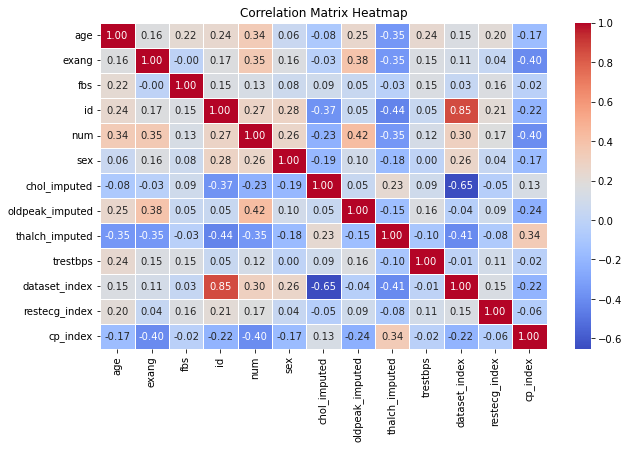

In [41]:
# Sample data columns based on the schema
columns = ["age", "exang", "fbs", "id", "num", "sex", "chol_imputed", "oldpeak_imputed",
           "thalch_imputed", "trestbps", "dataset_index", "restecg_index", "cp_index"]

df_pandas = df_indexed.select(columns).toPandas()

# Compute correlation matrix
correlation_matrix = df_pandas.corr()

# 1️⃣ Heatmap for Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize the plot
plt.title("Correlation Matrix Heatmap")
plt.show()

**Why Remove dataset_index?
    Irrelevance to Prediction**

**The dataset index represents the original source of the data (e.g., Cleveland, Hungary, etc.). However, this categorical information may not contribute significantly to predicting heart disease.**

In [42]:
df_indexed = df_indexed.drop("dataset_index")
df_indexed.printSchema()

root
 |-- age: long (nullable = true)
 |-- exang: integer (nullable = false)
 |-- fbs: integer (nullable = false)
 |-- id: long (nullable = true)
 |-- num: long (nullable = true)
 |-- sex: integer (nullable = false)
 |-- chol_imputed: double (nullable = true)
 |-- oldpeak_imputed: double (nullable = true)
 |-- thalch_imputed: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- restecg_index: double (nullable = false)
 |-- cp_index: double (nullable = false)



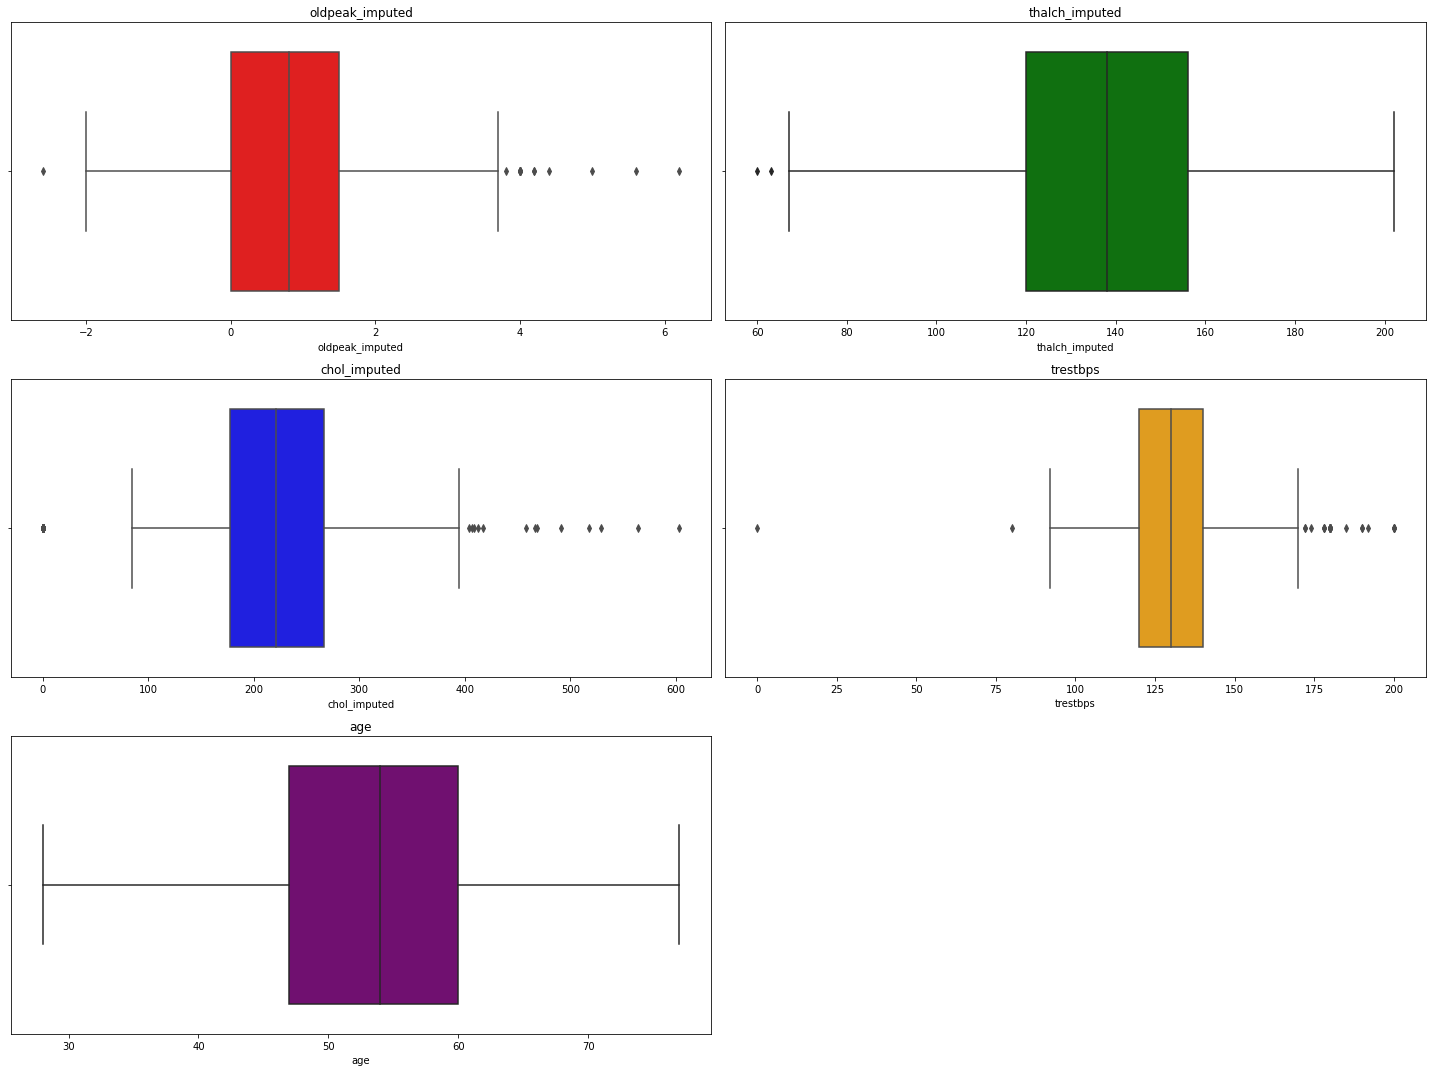

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_indexed.toPandas()

# List of numeric columns to visualize
numeric_cols = ['oldpeak_imputed', 'thalch_imputed', 'chol_imputed', 'trestbps', 'age']

# Determine number of rows and columns for subplots
num_cols = len(numeric_cols)
num_rows = math.ceil(num_cols / 2)

# Define a color palette for the plots
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'brown']

# Create boxplots for each numeric column
plt.figure(figsize=(20, num_rows * 5))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, 2, i + 1)  # Organize plots into rows and columns
    sns.boxplot(x=df_pandas[col], color=colors[i % len(colors)])
    plt.title(col)

plt.tight_layout()
plt.show()


In [44]:
from pyspark.sql.functions import col

df_indexed = df_indexed.filter(col("trestbps") != 0)


In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler


feature_columns = [col for col in df_indexed.columns if col != "num" and col != "id"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="features_normalized")
pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(df_indexed)
df_normalized = pipeline_model.transform(df_indexed)




In [46]:
df_normalized.show()

+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+--------+--------------------+--------------------+
|age|exang|fbs| id|num|sex|chol_imputed|oldpeak_imputed|thalch_imputed|trestbps|restecg_index|cp_index|            features| features_normalized|
+---+-----+---+---+---+---+------------+---------------+--------------+--------+-------------+--------+--------------------+--------------------+
| 63|    0|  1|  1|  0|  1|       233.0|            2.3|         150.0|   145.0|          1.0|     3.0|[63.0,0.0,1.0,1.0...|[0.71428571428571...|
| 67|    1|  0|  2|  2|  1|       286.0|            1.5|         108.0|   160.0|          1.0|     0.0|[67.0,1.0,0.0,1.0...|[0.79591836734693...|
| 67|    1|  0|  3|  1|  1|       229.0|            2.6|         129.0|   120.0|          1.0|     0.0|[67.0,1.0,0.0,1.0...|[0.79591836734693...|
| 37|    0|  0|  4|  0|  1|       250.0|            3.5|         187.0|   130.0|          0.0|     1.0|[37.0,0.0,0.0,1.0...|

In [47]:
feature_columns


['age',
 'exang',
 'fbs',
 'sex',
 'chol_imputed',
 'oldpeak_imputed',
 'thalch_imputed',
 'trestbps',
 'restecg_index',
 'cp_index']

In [48]:
train_ratio = 0.85
test_ratio = 1 - train_ratio

df_train, df_test = df_normalized.randomSplit([train_ratio, test_ratio], seed=42)

#df_test, df_validation = df_test.randomSplit([0.7, 0.3], seed=42)

# Step 2: Extract features (X) and labels (Y) for training and testing sets
X_train = df_train.select("features_normalized")
y_train = df_train.select(col("num").alias("label"))

#X_validation = df_validation.select("features_normalized")
#y_validation = df_validation.select(col("num").alias("label"))

X_test = df_test.select("features_normalized")
y_test = df_test.select(col("num").alias("label"))

# Step 3: Show the size of the training and testing sets
train_count = df_train.count()
#validation_count = df_validation.count()
test_count = df_test.count()

#print(f"Training Set: {train_count} samples | Test Set: {test_count} samples | Validation Set: {validation_count} samples")
print(f"Training Set: {train_count} samples | Test Set: {test_count} samples")


Training Set: 774 samples | Test Set: 145 samples


In [49]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

# Define a function that returns the number of elements in a vector
def vector_size(v):
    return len(v)

# Register the function as a UDF (User Defined Function)
vector_size_udf = udf(vector_size, IntegerType())

# Add a new column containing the vector size and display the results
df_train.select(vector_size_udf("features_normalized").alias("vector_size")).show()

# Show distinct vector sizes (e.g., to verify consistency in feature dimensions)
df_train.select(vector_size_udf("features_normalized")).distinct().show()


+-----------+
|vector_size|
+-----------+
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
|         10|
+-----------+
only showing top 20 rows



+--------------------------------+
|vector_size(features_normalized)|
+--------------------------------+
|                              10|
+--------------------------------+



In [50]:
X_train.show(10, truncate=False)
y_train.show(10)

df_train.select("features_normalized").count()


+----------------------------------------------------------------------------------------------------------------------------------------------------+
|features_normalized                                                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.18367346938775508,0.0,0.0,1.0,0.41459369817578773,0.6931818181818181,0.8943661971830986,0.4166666666666667,0.0,0.3333333333333333]               |
|[0.26530612244897955,0.0,0.0,0.0,0.3383084577114428,0.45454545454545453,0.7887323943661972,0.4166666666666667,0.3333333333333333,0.6666666666666666]|
|[0.5102040816326531,1.0,1.0,1.0,0.33665008291873966,0.6477272727272727,0.6690140845070423,0.5,0.3333333333333333,0.0]                               |
|[0.5714285714285714,0.0,0.0,1.0,0.3913764510779436,0.3863636363636364,0.8309859154929577,0.33

774

In [51]:
df_train = df_train.withColumnRenamed("num", "label")
df_test = df_test.withColumnRenamed("num", "label")
#df_validation = df_validation.withColumnRenamed("num", "label")

In [52]:
df_train = df_train.withColumn("label", when(df_train["label"] > 0, 1).otherwise(0))
df_test = df_test.withColumn("label", when(df_test["label"] > 0, 1).otherwise(0))
#df_validation = df_validation.withColumn("label", when(df_validation["label"] > 0, 1).otherwise(0))

In [53]:

train_count = df_train.count()
#validation_count = df_validation.count()
test_count = df_test.count()

#print(f"Training Set: {train_count} samples | Test Set: {test_count} samples | Validation Set: {validation_count} samples")
print(f"Training Set: {train_count} samples | Test Set: {test_count} samples")


Training Set: 774 samples | Test Set: 145 samples


In [54]:
def compare_models(df_train, df_test, features_col="features_normalized", label_col="label"):

    from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator

    # Define models for comparison with reasonable hyperparameters
    models = {
        "Logistic Regression": LogisticRegression(
            featuresCol=features_col,
            labelCol=label_col,
            maxIter=200,          # Maximum number of iterations
            regParam=0.01         # Regularization parameter (L2)
        ),

        "Decision Tree": DecisionTreeClassifier(
            featuresCol=features_col,
            labelCol=label_col,
            maxDepth=10,          # Limit tree depth to avoid overfitting
            seed=42               # Ensure reproducibility
        ),

        "Random Forest": RandomForestClassifier(
            featuresCol=features_col,
            labelCol=label_col,
            numTrees=100,             # Number of trees in the forest
            maxDepth=10,              # Limit each tree's depth
            minInstancesPerNode=4,    # Minimum number of samples to split
            minInfoGain=0.0           # Minimum gain required to split
        ),

        "Gradient Boosted Trees": GBTClassifier(
            featuresCol=features_col,
            labelCol=label_col,
            maxDepth=3,               # Depth of each tree
            maxIter=50,              # Number of boosting iterations (trees)
            stepSize=0.1,            # Learning rate
            subsamplingRate=1.0,     # Use all data for each iteration
            seed=42                  # For reproducibility
        )
    }

    # Define evaluator using accuracy metric
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, metricName="accuracy")
    results = []
    best_model = None
    best_accuracy = 0.0

    for model_name, model in models.items():
        # Train the model using the training set
        trained_model = model.fit(df_train)

        # Generate predictions on the test set
        predictions_test = trained_model.transform(df_test)

        # Evaluate test set accuracy
        accuracy_test = evaluator.evaluate(predictions_test)

        # Store model name and accuracy score
        results.append((model_name, accuracy_test))

        # Keep track of the best model (highest accuracy)
        if accuracy_test > best_accuracy:
            best_accuracy = accuracy_test
            best_model = trained_model

    # Convert the list of results into a Spark DataFrame
    results_df = spark.createDataFrame(results, ["Model", "Test Accuracy"])

    return results_df, best_model

# Run the function and get comparison results and the best model
model_comparison_results, best_trained_model = compare_models(df_train, df_test)

# Output the best model selected
print(f"Best Model Selected: {best_trained_model}")


25/03/23 11:39:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/23 11:39:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


25/03/23 11:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1143.2 KiB


25/03/23 11:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1492.2 KiB


25/03/23 11:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1782.6 KiB


25/03/23 11:39:57 WARN DAGScheduler: Broadcasting large task binary with size 1993.7 KiB


25/03/23 11:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1097.1 KiB


Best Model Selected: LogisticRegressionModel: uid=LogisticRegression_1109981d4bd9, numClasses=2, numFeatures=10


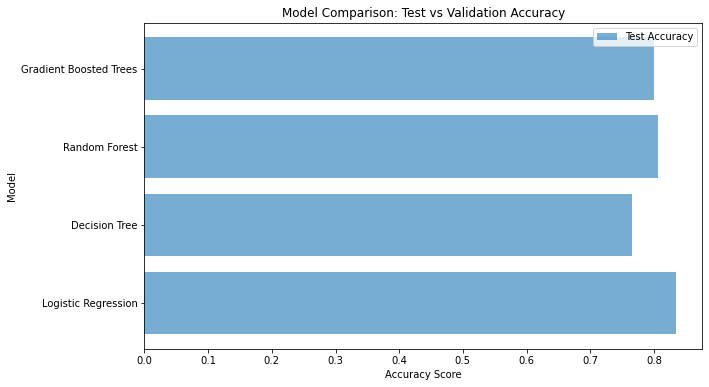

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the data to a Pandas DataFrame
model_comparison_pandas = model_comparison_results.toPandas()

# Create a comparison bar chart
plt.figure(figsize=(10, 6))

# Plot model accuracy on the test set
plt.barh(model_comparison_pandas["Model"], model_comparison_pandas["Test Accuracy"], alpha=0.6, label="Test Accuracy")

# Add labels and title
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Model Comparison: Test vs Validation Accuracy")
plt.legend()

# Display the plot
plt.show()


In [56]:
model_comparison_results.show()


+--------------------+------------------+
|               Model|     Test Accuracy|
+--------------------+------------------+
| Logistic Regression|0.8344827586206897|
|       Decision Tree|0.7655172413793103|
|       Random Forest|0.8068965517241379|
|Gradient Boosted ...|               0.8|
+--------------------+------------------+



In [57]:
best_trained_model

LogisticRegressionModel: uid=LogisticRegression_1109981d4bd9, numClasses=2, numFeatures=10

In [58]:
import json
from confluent_kafka import Consumer, Producer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer
import time


In [59]:
# Kafka Configuration
consumer_config = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'test-group',
    'auto.offset.reset': 'earliest'
}
consumer = Consumer(consumer_config)
consumer.subscribe(['test'])  # Subscribe to Kafka topic

producer_config = {'bootstrap.servers': 'localhost:9092'}
producer = Producer(producer_config)
KAFKA_TOPIC_OUTPUT = "prediction"

# Initialize Spark Session
spark = SparkSession.builder.appName("KafkaConsumer").getOrCreate()
received_test_rdd = spark.sparkContext.emptyRDD()


25/03/23 11:41:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [60]:
def process_data():
    """
    Convert RDD to DataFrame and rename columns.
    """
    df = spark.createDataFrame(received_test_rdd)
    rename_dict = {
        'age': 'age',
        'chol': 'chol_imputed',
        'cp': 'cp_index',
        'exang': 'exang',
        'fbs': 'fbs',
        'oldpeak': 'oldpeak_imputed',
        'restecg': 'restecg_index',
        'sex': 'sex',
        'thalch': 'thalch_imputed',
        'trestbps': 'trestbps'
    }
    for old_col, new_col in rename_dict.items():
        df = df.withColumnRenamed(old_col, new_col)
    return df

def normalize_features(df):
    """
    Assemble and normalize feature vectors.
    """
    feature_columns = [col for col in df.columns if col != "num" and col != "id"]
    df_vectorized = pipeline_model.transform(df)
    return df_vectorized

def predict(df_normalized, model):
    """
    Run the trained model on new data.
    """
    return model.transform(df_normalized)

def send_predictions_to_kafka(predictions):
    """
    Sends only the first model prediction to Kafka topic.
    """
    first_row = predictions.select("prediction").first()
    if first_row:
        prediction_value = first_row["prediction"]
        prediction_data = {"prediction": float(prediction_value)}
        producer.produce(KAFKA_TOPIC_OUTPUT, json.dumps(prediction_data).encode('utf-8'))
        producer.flush()
        print(f"📤 Sent Single Prediction: {prediction_data}")
    else:
        print("⚠ No prediction available to send!")

In [61]:
def consume_messages2(best_trained_model):
    """
    Kafka message consumer that processes incoming data, transforms it,
    runs predictions, and sends results back to Kafka.
    """
    global received_test_rdd
    
    try:
        while True:
            msg = consumer.poll(1.0)
            if msg is None:
                continue
            if msg.error():
                print(f"Consumer error: {msg.error()}")
                continue
            
            data = json.loads(msg.value().decode('utf-8'))
            received_test_rdd = spark.sparkContext.parallelize([data])  # Overwrite instead of append

            
            print(f"✅ Received record: {data}, Total stored in RDD: {received_test_rdd.count()}")
            
            # Process and predict
            time.sleep(1)  # Suspension for 1 second
            df = process_data()
            df_normalized = normalize_features(df)
            df_normalized.show()
            predictions = predict(df_normalized, best_trained_model)
            predictions.select("features_normalized", "prediction").show(truncate=False)
            
            send_predictions_to_kafka(predictions)
    
    except KeyboardInterrupt:
        print("Consumer interrupted. Closing connection...")
    finally:
        consumer.close()
        print(f"📊 Total number of records received in RDD: {received_test_rdd.count()}")

In [ ]:
consume_messages2(best_trained_model)

Consumer error: KafkaError{code=UNKNOWN_TOPIC_OR_PART,val=3,str="Subscribed topic not available: test: Broker: Unknown topic or partition"}
✅ Received record: {'age': 85, 'sex': 0, 'trestbps': 80, 'chol': 100, 'fbs': 0, 'restecg': 1, 'thalch': 50, 'exang': 1, 'oldpeak': 0.6, 'cp': 2}, Total stored in RDD: 1
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+
|age|chol_imputed|cp_index|exang|fbs|oldpeak_imputed|restecg_index|sex|thalch_imputed|trestbps|            features| features_normalized|
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+
| 85|         100|       2|    1|  0|            0.6|            1|  0|            50|      80|[85.0,1.0,0.0,0.0...|[1.16326530612244...|
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+



📤 Sent Single Prediction: {'prediction': 0.0}
✅ Received record: {'age': 63, 'sex': 1, 'trestbps': 145, 'chol': 233, 'fbs': 1, 'restecg': 1, 'thalch': 150, 'exang': 0, 'oldpeak': 2.3, 'cp': 2}, Total stored in RDD: 1
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+
|age|chol_imputed|cp_index|exang|fbs|oldpeak_imputed|restecg_index|sex|thalch_imputed|trestbps|            features| features_normalized|
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+
| 63|         233|       2|    0|  1|            2.3|            1|  1|           150|     145|[63.0,0.0,1.0,1.0...|[0.71428571428571...|
+---+------------+--------+-----+---+---------------+-------------+---+--------------+--------+--------------------+--------------------+

+-------------------------------------------------------------------------------------------